In [1]:
import os

directory = 'C:\\Users\\User\\OneDrive - Asia Pacific University\\FYP\\NewData'
train_dir = os.path.join(directory, 'train')
val_dir = os.path.join(directory, 'val')
test_dir = os.path.join(directory, 'test')

SVM with EfficientNetB0

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

batch_size = 32
img_size   = (224, 224)
datagen    = ImageDataGenerator(preprocessing_function=preprocess_input)

#extract embeddings
feature_extractor = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

def extract_embeddings(directory):
    gen = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )
    X = feature_extractor.predict(gen, verbose=1)
    y = gen.classes
    return X, y, list(gen.class_indices.keys())

X_train, y_train, class_names = extract_embeddings(train_dir)
X_val,   y_val,   _           = extract_embeddings(val_dir)
X_test,  y_test,  _           = extract_embeddings(test_dir)

#SMOTE
sm     = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Original train distribution:", np.bincount(y_train))
print("After SMOTE:               ", np.bincount(y_res))

svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_res, y_res)

#evaluation
for split_name, X_split, y_split in [
    ("Training (SMOTE)", X_res, y_res),
    ("Validation",      X_val, y_val),
    ("Test",            X_test, y_test)
]:
    y_pred = svm_clf.predict(X_split)
    acc    = accuracy_score(y_split, y_pred)
    print(f"\n📊 SVM Classification Report ({split_name}):")
    print(classification_report(y_split, y_pred, target_names=class_names, digits=4))
    print(f"{split_name} Accuracy: {acc:.4f}")


Found 15251 images belonging to 5 classes.


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


477/477 ━━━━━━━━━━━━━━━━━━━━ 317s 662ms/step
Found 1906 images belonging to 5 classes.
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 939ms/step
Found 1907 images belonging to 5 classes.
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 981ms/step
Original train distribution: [4208 4051 2448 2374 2170]
After SMOTE:                [4208 4208 4208 4208 4208]

📊 SVM Classification Report (Training (SMOTE)):
              precision    recall  f1-score   support

           0     0.8485    0.8667    0.8575      4208
           1     0.8329    0.7488    0.7886      4208
           2     0.7856    0.8351    0.8096      4208
           3     0.8902    0.8569    0.8732      4208
           4     0.9152    0.9646    0.9393      4208

    accuracy                         0.8544     21040
   macro avg     0.8545    0.8544    0.8536     21040
weighted avg     0.8545    0.8544    0.8536     21040

Training (SMOTE) Accuracy: 0.8544

📊 SVM Classification Report (Validation):
              precision    recall  f1-score   support

      

Hyperparameter Tuning

RandomizedSearchCV

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = {
    'C':     loguniform(1e-3, 1e3),
    'gamma': loguniform(1e-4, 1e-1),
}

rs = RandomizedSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,         
    n_jobs=1,     
    random_state=42,
    verbose=1
)

rs.fit(X_res, y_res)

print("Best hyperparameters:", rs.best_params_)
print("Best CV accuracy:   ", rs.best_score_)

best_svm = rs.best_estimator_

for split_name, X_split, y_split in [
    ("Train (SMOTE)", X_res, y_res),
    ("Validation",    X_val, y_val),
]:
    y_pred = best_svm.predict(X_split)
    acc    = accuracy_score(y_split, y_pred)
    print(f"\n=== {split_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_split, y_pred, target_names=class_names, digits=4))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'C': 24.658329458549105, 'gamma': 0.006251373574521752}
Best CV accuracy:    0.8790871673098094

=== Train (SMOTE) ===
Accuracy: 0.9982
              precision    recall  f1-score   support

           0     0.9957    0.9979    0.9968      4208
           1     0.9976    0.9941    0.9958      4208
           2     0.9983    0.9995    0.9989      4208
           3     0.9995    0.9998    0.9996      4208
           4     1.0000    1.0000    1.0000      4208

    accuracy                         0.9982     21040
   macro avg     0.9982    0.9982    0.9982     21040
weighted avg     0.9982    0.9982    0.9982     21040


=== Validation ===
Accuracy: 0.8741
              precision    recall  f1-score   support

           0     0.8693    0.8726    0.8710       526
           1     0.8591    0.8557    0.8574       506
           2     0.8459    0.8072    0.8261       306
           3     0.8762    0.9057    

Optuna

In [4]:
import optuna
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def objective(trial):
    k      = trial.suggest_categorical('k_neighbors', [3, 5, 7])
    C      = trial.suggest_float('C', 1e-2, 1e2, log=True)
    gamma  = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)

    pipe = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=k)),
        ('svm',   SVC(kernel='rbf', C=C, gamma=gamma,
                      probability=True, random_state=42, verbose=False))
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring='accuracy',
                             n_jobs=1)

    mean_score = float(np.mean(scores))
    print(f"Trial {trial.number}: k={k}, C={C:.3g}, γ={gamma:.3g} → CV acc={mean_score:.4f}")
    return mean_score

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n🔍 Best hyperparameters:", study.best_params)
print(f"🔍 Best CV accuracy:   {study.best_value:.4f}")

best = study.best_params
best_pipe = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=best['k_neighbors'])),
    ('svm',   SVC(kernel='rbf',
                  C=best['C'],
                  gamma=best['gamma'],
                  probability=True,
                  random_state=42))
])
best_pipe.fit(X_train, y_train)

for name, X_split, y_split in [
    ("Train",      X_train, y_train),
    ("Validation", X_val,   y_val),
]:
    y_pred = best_pipe.predict(X_split)
    acc    = accuracy_score(y_split, y_pred)
    print(f"\n📊 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_split, y_pred,
                                target_names=class_names,
                                digits=4))


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-03 08:27:26,045] A new study created in memory with name: no-name-53885531-816a-49f9-9a46-3eee0f704f5b
Best trial: 0. Best value: 0.840469:   3%|▎         | 1/30 [32:45<15:50:05, 1965.72s/it]

Trial 0: k=7, C=46.5, γ=0.0158 → CV acc=0.8405
[I 2025-07-03 09:00:11,808] Trial 0 finished with value: 0.8404693728481712 and parameters: {'k_neighbors': 7, 'C': 46.47234482896025, 'gamma': 0.01579560055203398}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:   7%|▋         | 2/30 [1:13:12<17:23:49, 2236.76s/it]

Trial 1: k=3, C=18.2, γ=0.000159 → CV acc=0.6883
[I 2025-07-03 09:40:38,295] Trial 1 finished with value: 0.6883476101075671 and parameters: {'k_neighbors': 3, 'C': 18.199594039444296, 'gamma': 0.00015864899408350172}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  10%|█         | 3/30 [2:17:08<22:15:13, 2967.17s/it]

Trial 2: k=5, C=6.76, γ=0.000174 → CV acc=0.6524
[I 2025-07-03 10:44:34,645] Trial 2 finished with value: 0.6523500863891759 and parameters: {'k_neighbors': 5, 'C': 6.7635657391949175, 'gamma': 0.00017404547915285572}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  13%|█▎        | 4/30 [3:33:05<25:57:49, 3594.98s/it]

Trial 3: k=7, C=3.69, γ=0.000227 → CV acc=0.6375
[I 2025-07-03 12:00:32,067] Trial 3 finished with value: 0.6375316739243687 and parameters: {'k_neighbors': 7, 'C': 3.689527125400414, 'gamma': 0.00022676837839974057}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  17%|█▋        | 5/30 [5:21:14<32:12:44, 4638.57s/it]

Trial 4: k=7, C=0.101, γ=0.032 → CV acc=0.6370
[I 2025-07-03 13:48:41,015] Trial 4 finished with value: 0.6370070364599111 and parameters: {'k_neighbors': 7, 'C': 0.10100001849147366, 'gamma': 0.03196300051507647}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  20%|██        | 6/30 [6:39:25<31:02:33, 4656.41s/it]

Trial 5: k=3, C=0.0103, γ=0.00416 → CV acc=0.4477
[I 2025-07-03 15:06:52,068] Trial 5 finished with value: 0.44770775749363606 and parameters: {'k_neighbors': 3, 'C': 0.010311377855588702, 'gamma': 0.004163161156967217}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  23%|██▎       | 7/30 [8:11:50<31:36:16, 4946.79s/it]

Trial 6: k=3, C=17.4, γ=0.0607 → CV acc=0.7871
[I 2025-07-03 16:39:16,697] Trial 6 finished with value: 0.787095659727516 and parameters: {'k_neighbors': 3, 'C': 17.38192509934518, 'gamma': 0.06071689376693213}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  27%|██▋       | 8/30 [10:01:48<33:26:35, 5472.53s/it]

Trial 7: k=5, C=20.8, γ=0.0509 → CV acc=0.8025
[I 2025-07-03 18:29:14,896] Trial 7 finished with value: 0.8025045328068101 and parameters: {'k_neighbors': 5, 'C': 20.82653384459619, 'gamma': 0.050942189948573496}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  30%|███       | 9/30 [11:50:06<33:47:29, 5792.85s/it]

Trial 8: k=5, C=0.0295, γ=0.00113 → CV acc=0.4497
[I 2025-07-03 20:17:32,104] Trial 8 finished with value: 0.4497402778188393 and parameters: {'k_neighbors': 5, 'C': 0.029501451268820755, 'gamma': 0.0011349209574300196}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 0. Best value: 0.840469:  33%|███▎      | 10/30 [12:37:00<27:04:27, 4873.38s/it]

Trial 9: k=5, C=2.47, γ=0.0081 → CV acc=0.8055
[I 2025-07-03 21:04:26,633] Trial 9 finished with value: 0.80545478495217 and parameters: {'k_neighbors': 5, 'C': 2.472104314541936, 'gamma': 0.008102885239582846}. Best is trial 0 with value: 0.8404693728481712.


Best trial: 10. Best value: 0.842174:  37%|███▋      | 11/30 [13:20:56<22:06:22, 4188.58s/it]

Trial 10: k=7, C=84.4, γ=0.0137 → CV acc=0.8422
[I 2025-07-03 21:48:22,459] Trial 10 finished with value: 0.8421740931122955 and parameters: {'k_neighbors': 7, 'C': 84.42153726085989, 'gamma': 0.013741016549712024}. Best is trial 10 with value: 0.8421740931122955.


Best trial: 11. Best value: 0.843092:  40%|████      | 12/30 [14:03:18<18:26:16, 3687.61s/it]

Trial 11: k=7, C=92.3, γ=0.0128 → CV acc=0.8431
[I 2025-07-03 22:30:44,270] Trial 11 finished with value: 0.8430920829107005 and parameters: {'k_neighbors': 7, 'C': 92.25412566098342, 'gamma': 0.012777471334201956}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  43%|████▎     | 13/30 [14:56:43<16:43:27, 3541.64s/it]

Trial 12: k=7, C=0.413, γ=0.00173 → CV acc=0.6345
[I 2025-07-03 23:24:10,009] Trial 12 finished with value: 0.6345153406507315 and parameters: {'k_neighbors': 7, 'C': 0.41259086137339884, 'gamma': 0.0017296730090424447}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  47%|████▋     | 14/30 [15:20:59<12:56:24, 2911.51s/it]

Trial 13: k=7, C=67.2, γ=0.0139 → CV acc=0.8420
[I 2025-07-03 23:48:25,487] Trial 13 finished with value: 0.8420429240719969 and parameters: {'k_neighbors': 7, 'C': 67.24851591284423, 'gamma': 0.01393899067819842}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  50%|█████     | 15/30 [15:37:38<9:43:44, 2334.97s/it] 

Trial 14: k=7, C=96.4, γ=0.00468 → CV acc=0.8372
[I 2025-07-04 00:05:04,184] Trial 14 finished with value: 0.837190907876535 and parameters: {'k_neighbors': 7, 'C': 96.39978378234228, 'gamma': 0.004679964912317518}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  53%|█████▎    | 16/30 [16:06:53<8:24:06, 2160.49s/it]

Trial 15: k=7, C=0.503, γ=0.0212 → CV acc=0.7690
[I 2025-07-04 00:34:19,632] Trial 15 finished with value: 0.7689985501106494 and parameters: {'k_neighbors': 7, 'C': 0.5031244213461366, 'gamma': 0.021157793181094856}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  57%|█████▋    | 17/30 [16:29:50<6:57:02, 1924.83s/it]

Trial 16: k=7, C=7.22, γ=0.000899 → CV acc=0.7292
[I 2025-07-04 00:57:16,416] Trial 16 finished with value: 0.729197717573566 and parameters: {'k_neighbors': 7, 'C': 7.218197953734504, 'gamma': 0.0008991968180200886}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  60%|██████    | 18/30 [17:23:26<7:42:35, 2312.94s/it]

Trial 17: k=7, C=33.7, γ=0.0949 → CV acc=0.6800
[I 2025-07-04 01:50:52,831] Trial 17 finished with value: 0.6799551391305071 and parameters: {'k_neighbors': 7, 'C': 33.65849191897905, 'gamma': 0.09489251818306833}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  63%|██████▎   | 19/30 [17:49:11<6:21:45, 2082.29s/it]

Trial 18: k=7, C=1.4, γ=0.00289 → CV acc=0.7228
[I 2025-07-04 02:16:37,817] Trial 18 finished with value: 0.7228373799543367 and parameters: {'k_neighbors': 7, 'C': 1.3955758780757233, 'gamma': 0.0028900136241271157}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  67%|██████▋   | 20/30 [18:08:46<5:01:37, 1809.76s/it]

Trial 19: k=3, C=92.1, γ=0.00837 → CV acc=0.8411
[I 2025-07-04 02:36:12,411] Trial 19 finished with value: 0.8411250761616283 and parameters: {'k_neighbors': 3, 'C': 92.05389394286041, 'gamma': 0.008367477533769534}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  70%|███████   | 21/30 [18:32:03<4:12:54, 1686.02s/it]

Trial 20: k=7, C=10.6, γ=0.00042 → CV acc=0.7091
[I 2025-07-04 02:59:29,939] Trial 20 finished with value: 0.7090677780575981 and parameters: {'k_neighbors': 7, 'C': 10.5680021845367, 'gamma': 0.0004196929160444926}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  73%|███████▎  | 22/30 [18:56:47<3:36:42, 1625.34s/it]

Trial 21: k=7, C=64.2, γ=0.0148 → CV acc=0.8415
[I 2025-07-04 03:24:13,754] Trial 21 finished with value: 0.8415184284955757 and parameters: {'k_neighbors': 7, 'C': 64.20961381224079, 'gamma': 0.014815105701894576}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  77%|███████▋  | 23/30 [19:16:57<2:55:04, 1500.66s/it]

Trial 22: k=7, C=36.6, γ=0.00826 → CV acc=0.8411
[I 2025-07-04 03:44:23,601] Trial 22 finished with value: 0.8410593820007235 and parameters: {'k_neighbors': 7, 'C': 36.57369754582507, 'gamma': 0.008261739792926243}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  80%|████████  | 24/30 [19:55:11<2:53:51, 1738.56s/it]

Trial 23: k=7, C=38.6, γ=0.0347 → CV acc=0.8241
[I 2025-07-04 04:22:37,103] Trial 23 finished with value: 0.8240769447986916 and parameters: {'k_neighbors': 7, 'C': 38.64461119832543, 'gamma': 0.03473451560371854}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  83%|████████▎ | 25/30 [20:17:02<2:14:11, 1610.30s/it]

Trial 24: k=7, C=98.1, γ=0.0132 → CV acc=0.8422
[I 2025-07-04 04:44:28,174] Trial 24 finished with value: 0.8422396969808136 and parameters: {'k_neighbors': 7, 'C': 98.06995614831726, 'gamma': 0.013195191556800849}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  87%|████████▋ | 26/30 [20:33:08<1:34:28, 1417.11s/it]

Trial 25: k=7, C=20.1, γ=0.00677 → CV acc=0.8423
[I 2025-07-04 05:00:34,598] Trial 25 finished with value: 0.8423052621525943 and parameters: {'k_neighbors': 7, 'C': 20.106239849788025, 'gamma': 0.006770735121381739}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  90%|█████████ | 27/30 [20:49:01<1:03:53, 1277.83s/it]

Trial 26: k=7, C=14.1, γ=0.00589 → CV acc=0.8380
[I 2025-07-04 05:16:27,472] Trial 26 finished with value: 0.8379777286346414 and parameters: {'k_neighbors': 7, 'C': 14.076720109582679, 'gamma': 0.005889671059542601}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  93%|█████████▎| 28/30 [21:08:55<41:45, 1252.79s/it]  

Trial 27: k=7, C=3.22, γ=0.00303 → CV acc=0.7667
[I 2025-07-04 05:36:21,822] Trial 27 finished with value: 0.7667034079287757 and parameters: {'k_neighbors': 7, 'C': 3.223052829824282, 'gamma': 0.003029583860574541}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092:  97%|█████████▋| 29/30 [21:24:05<19:09, 1149.84s/it]

Trial 28: k=3, C=35.4, γ=0.00203 → CV acc=0.8134
[I 2025-07-04 05:51:31,439] Trial 28 finished with value: 0.8133890478636848 and parameters: {'k_neighbors': 3, 'C': 35.42049579961909, 'gamma': 0.002032411286654057}. Best is trial 11 with value: 0.8430920829107005.


Best trial: 11. Best value: 0.843092: 100%|██████████| 30/30 [21:54:28<00:00, 2628.94s/it]

Trial 29: k=5, C=7.04, γ=0.0255 → CV acc=0.8324
[I 2025-07-04 06:21:54,404] Trial 29 finished with value: 0.8324040440876571 and parameters: {'k_neighbors': 5, 'C': 7.035622044878648, 'gamma': 0.025541765188764803}. Best is trial 11 with value: 0.8430920829107005.

🔍 Best hyperparameters: {'k_neighbors': 7, 'C': 92.25412566098342, 'gamma': 0.012777471334201956}
🔍 Best CV accuracy:   0.8431



📊 Train Accuracy: 0.9993
              precision    recall  f1-score   support

           0     0.9986    0.9990    0.9988      4208
           1     0.9990    0.9985    0.9988      4051
           2     1.0000    1.0000    1.0000      2448
           3     1.0000    1.0000    1.0000      2374
           4     1.0000    1.0000    1.0000      2170

    accuracy                         0.9993     15251
   macro avg     0.9995    0.9995    0.9995     15251
weighted avg     0.9993    0.9993    0.9993     15251


📊 Validation Accuracy: 0.8820
              precision    recall  f1-score   support

           0     0.8731    0.8897    0.8814       526
           1     0.8631    0.8597    0.8614       506
           2     0.8834    0.8170    0.8489       306
           3     0.8710    0.9091    0.8896       297
           4     0.9451    0.9520    0.9485       271

    accuracy                         0.8820      1906
   macro avg     0.8871    0.8855    0.8860      1906
weighted avg     0.8

Best Model

In [7]:
y_pred = best_pipe.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
print(f"\n📊Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred,
                                target_names=class_names,
                                digits=4))


📊Test Accuracy: 0.8715
              precision    recall  f1-score   support

           0     0.8872    0.8821    0.8847       526
           1     0.8301    0.8481    0.8390       507
           2     0.8301    0.8301    0.8301       306
           3     0.8870    0.8721    0.8795       297
           4     0.9515    0.9410    0.9462       271

    accuracy                         0.8715      1907
   macro avg     0.8772    0.8747    0.8759      1907
weighted avg     0.8720    0.8715    0.8717      1907



Save Model

In [ ]:
import joblib
import json
from sklearn.metrics import classification_report

joblib.dump(best_pipe, 'svm_best_pipeline.pkl')
print("SVM pipeline saved as 'svm_best_pipeline.pkl'")

study_results = {
    "best_params": study.best_params,
    "best_value": study.best_value
}

with open("svm_optuna_results.json", "w") as f:
    json.dump(study_results, f, indent=4)

print("Optuna results saved to svm_optuna_results.json")

report_dict = {}
for name, X_split, y_split in [
    ("Train",      X_train, y_train),
    ("Validation", X_val,   y_val),
    ("Test",       X_test,  y_test),
]:
    y_pred = best_pipe.predict(X_split)
    report = classification_report(
        y_split, y_pred,
        target_names=class_names,
        digits=4,
        output_dict=True
    )
    report_dict[name] = report

with open("svm_classification_reports.json", "w") as f:
    json.dump(report_dict, f, indent=4)

print("Classification reports saved to svm_classification_reports.json")


SVM pipeline saved as 'svm_best_pipeline.pkl'
Optuna results saved to svm_optuna_results.json
Classification reports saved to svm_classification_reports.json


Graphs

Learning Curve

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\skle

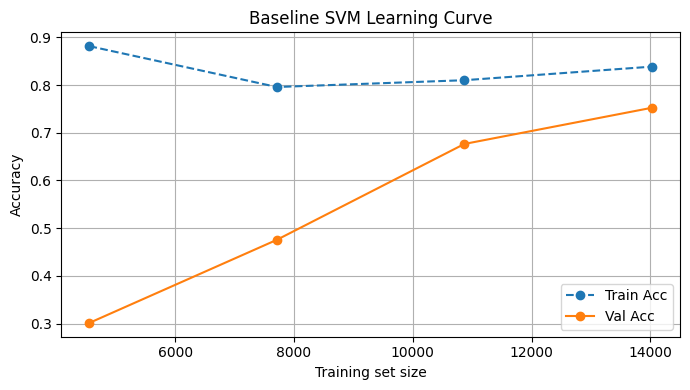

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\imbl

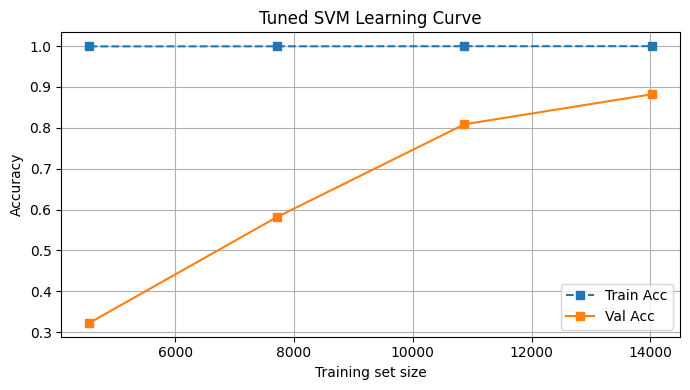

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, 5)
ts_base, train_scores_base, val_scores_base = learning_curve(
    estimator=svm_clf,
    X=X_res, y=y_res,
    train_sizes=train_sizes,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=0
)
train_mean_base = train_scores_base.mean(axis=1)
val_mean_base   = val_scores_base.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(ts_base, train_mean_base, 'o--', label='Train Acc')
plt.plot(ts_base, val_mean_base,   'o-',  label='Val Acc')
plt.title("Baseline SVM Learning Curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

ts_tuned, train_scores_tuned, val_scores_tuned = learning_curve(
    estimator=best_pipe,
    X=X_res, y=y_res,
    train_sizes=train_sizes,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=0
)
train_mean_tuned = train_scores_tuned.mean(axis=1)
val_mean_tuned   = val_scores_tuned.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(ts_tuned, train_mean_tuned, 's--', label='Train Acc')
plt.plot(ts_tuned, val_mean_tuned,   's-',  label='Val Acc')
plt.title("Tuned SVM Learning Curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

Loss Curve

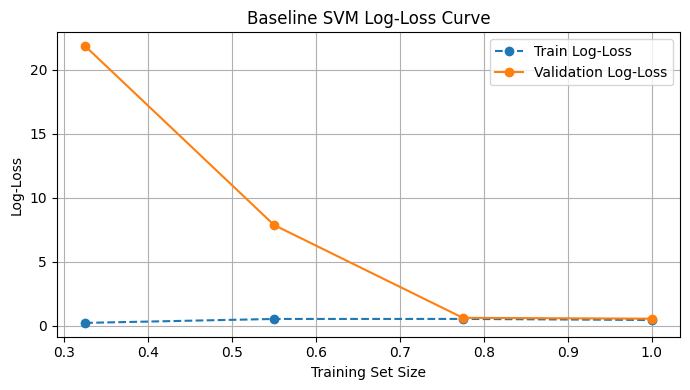

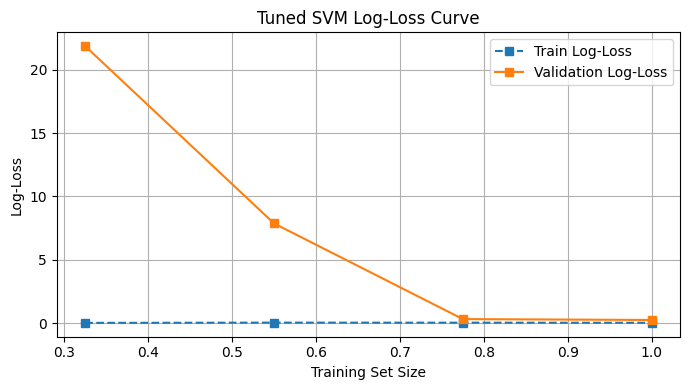

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.base import clone

def safe_log_loss(y_true, y_pred, labels_list):
    n_classes = len(labels_list)
    y_pred_fixed = np.zeros((y_pred.shape[0], n_classes))
    classes_in_pred = np.unique(np.argmax(y_pred, axis=1))
    for i, class_idx in enumerate(classes_in_pred):
        y_pred_fixed[:, class_idx] = y_pred[:, i]
    return log_loss(y_true, y_pred_fixed, labels=labels_list)

def compute_learning_curve(estimator, X, y, train_sizes, cv, labels_list):
    train_losses = []
    val_losses = []

    for frac in train_sizes:
        frac_train_losses = []
        frac_val_losses = []

        for train_idx, val_idx in cv.split(X, y):
            y_train_split = y[train_idx]
            if len(np.unique(y_train_split)) < 2:
                # Skip fold with only one class
                continue

            n_train = int(len(train_idx) * frac)
            if n_train < 2:
                # Skip too-small training subset
                continue

            sub_train_idx = train_idx[:n_train]
            y_sub_train_split = y[sub_train_idx]
            if len(np.unique(y_sub_train_split)) < 2:
                # Skip training subset with only one class
                continue

            X_train_sub = X[sub_train_idx]
            y_train_sub = y[sub_train_idx]

            model = clone(estimator)
            model.fit(X_train_sub, y_train_sub)

            y_train_pred = model.predict_proba(X_train_sub)
            y_val_pred   = model.predict_proba(X[val_idx])

            train_loss = safe_log_loss(y_train_sub, y_train_pred, labels_list)
            val_loss   = safe_log_loss(y[val_idx], y_val_pred, labels_list)

            frac_train_losses.append(train_loss)
            frac_val_losses.append(val_loss)

        if frac_train_losses and frac_val_losses:
            train_losses.append(np.mean(frac_train_losses))
            val_losses.append(np.mean(frac_val_losses))
        else:
            train_losses.append(np.nan)
            val_losses.append(np.nan)

    return train_sizes, train_losses, val_losses

# Baseline SVM
labels_list = np.unique(y_res)
train_sizes = np.linspace(0.1, 1.0, 5)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Baseline
ts_base, train_loss_base, val_loss_base = compute_learning_curve(svm_clf, X_res, y_res, train_sizes, cv, labels_list)

plt.figure(figsize=(7,4))
plt.plot(ts_base, train_loss_base, 'o--', label='Train Log-Loss')
plt.plot(ts_base, val_loss_base,   'o-',  label='Validation Log-Loss')
plt.title("Baseline SVM Log-Loss Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Log-Loss")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tuned
ts_tuned, train_loss_tuned, val_loss_tuned = compute_learning_curve(best_pipe, X_res, y_res, train_sizes, cv, labels_list)

plt.figure(figsize=(7,4))
plt.plot(ts_tuned, train_loss_tuned, 's--', label='Train Log-Loss')
plt.plot(ts_tuned, val_loss_tuned,   's-',  label='Validation Log-Loss')
plt.title("Tuned SVM Log-Loss Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Log-Loss")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Confusion Matrix

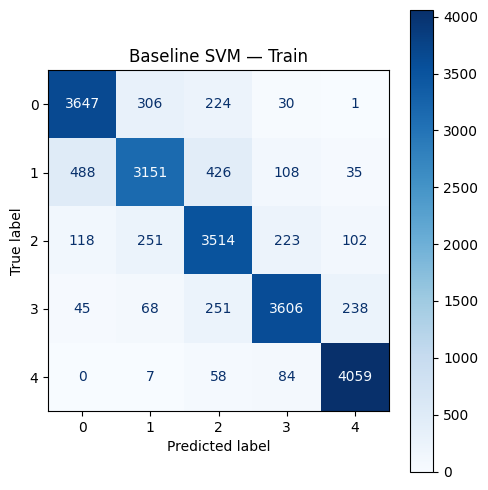

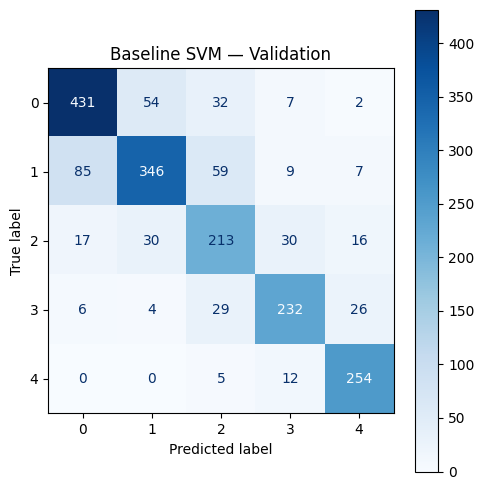

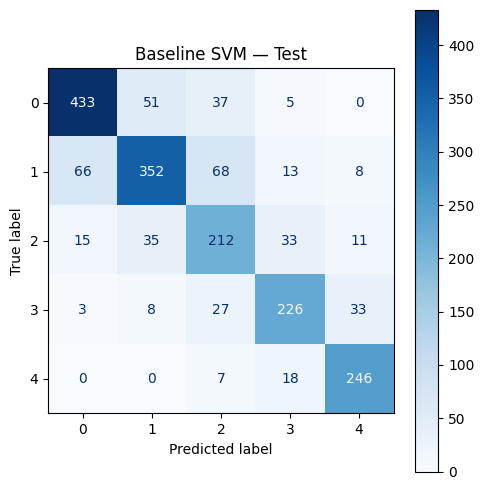

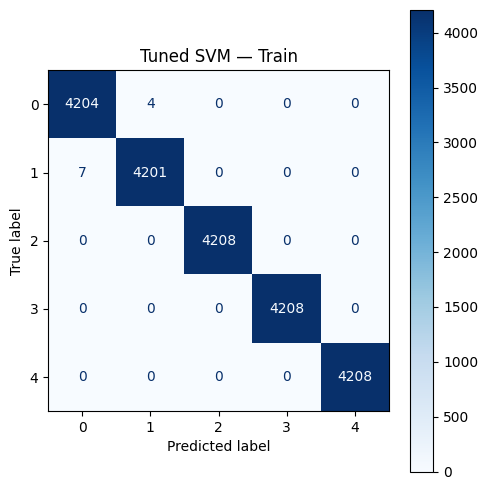

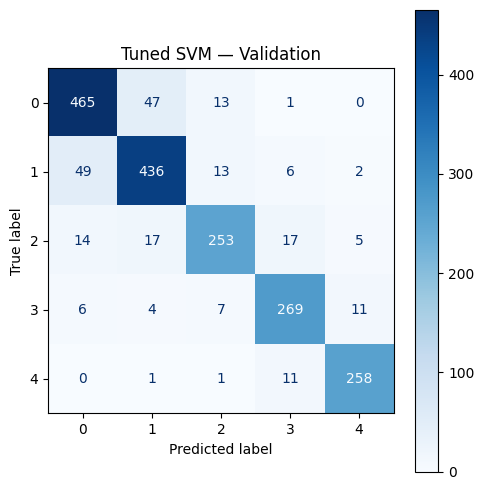

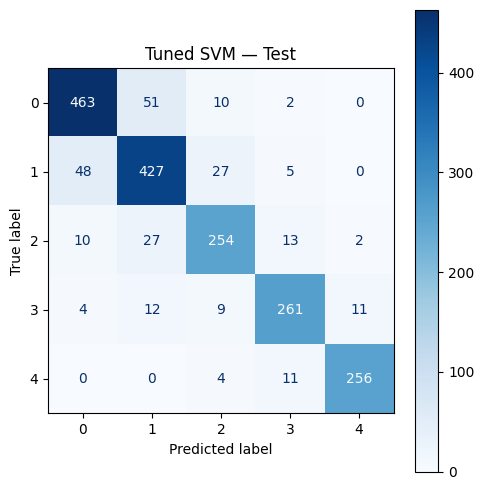

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

splits = [
    ("Train", X_res, y_res),
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test),
]

# Baseline SVM
for split_name, X_split, y_split in splits:
    y_pred = svm_clf.predict(X_split)
    cm = confusion_matrix(y_split, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    plt.figure(figsize=(5,5))
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f"Baseline SVM — {split_name}")
    plt.tight_layout()
    plt.show()

# Tuned SVM
for split_name, X_split, y_split in splits:
    y_pred = best_pipe.predict(X_split)
    cm = confusion_matrix(y_split, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    plt.figure(figsize=(5,5))
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f"Tuned SVM — {split_name}")
    plt.tight_layout()
    plt.show()


ROC Curve

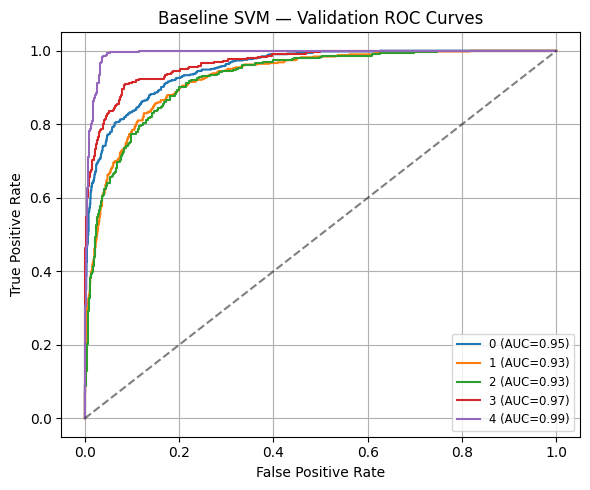

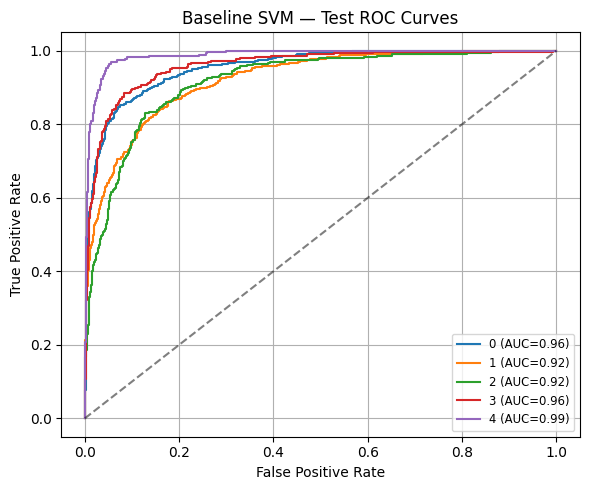

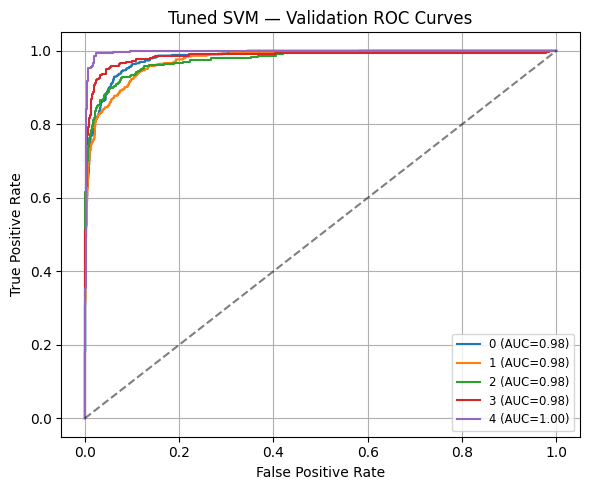

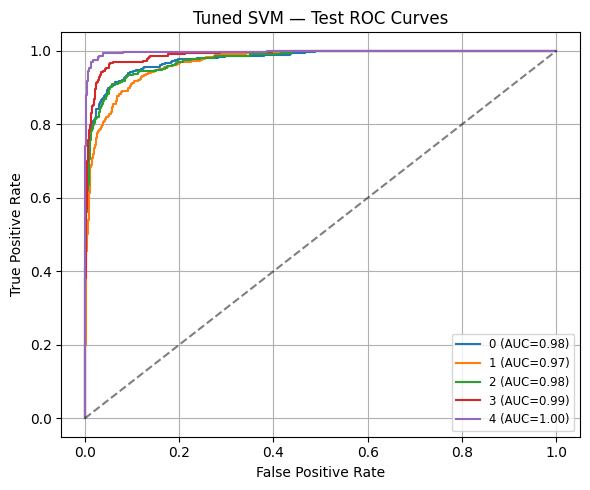

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes   = len(class_names)
y_val_bin   = label_binarize(y_val,  classes=range(n_classes))
y_test_bin  = label_binarize(y_test, classes=range(n_classes))

#Baseline SVM
y_val_score_base   = svm_clf.predict_proba(X_val)
y_test_score_base  = svm_clf.predict_proba(X_test)

#Tuned SVM
y_val_score_best   = best_pipe.predict_proba(X_val)
y_test_score_best  = best_pipe.predict_proba(X_test)

fpr_base_val, tpr_base_val, auc_base_val   = {}, {}, {}
fpr_base_test, tpr_base_test, auc_base_test = {}, {}, {}

fpr_best_val, tpr_best_val, auc_best_val   = {}, {}, {}
fpr_best_test, tpr_best_test, auc_best_test = {}, {}, {}

for i in range(n_classes):
    fpr_base_val[i], tpr_base_val[i], _  = roc_curve(y_val_bin[:, i], y_val_score_base[:, i])
    auc_base_val[i]  = auc(fpr_base_val[i], tpr_base_val[i])

    fpr_base_test[i], tpr_base_test[i], _  = roc_curve(y_test_bin[:, i], y_test_score_base[:, i])
    auc_base_test[i]  = auc(fpr_base_test[i], tpr_base_test[i])
    

    fpr_best_val[i], tpr_best_val[i], _ = roc_curve(y_val_bin[:, i], y_val_score_best[:, i])
    auc_best_val[i]  = auc(fpr_best_val[i], tpr_best_val[i])
    
    fpr_best_test[i], tpr_best_test[i], _ = roc_curve(y_test_bin[:, i], y_test_score_best[:, i])
    auc_best_test[i]  = auc(fpr_best_test[i], tpr_best_test[i])

# Baseline SVM — Validation ROC
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    plt.plot(fpr_base_val[i], tpr_base_val[i],
             label=f"{class_names[i]} (AUC={auc_base_val[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("Baseline SVM — Validation ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Baseline SVM — Test ROC
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    plt.plot(fpr_base_test[i], tpr_base_test[i],
             label=f"{class_names[i]} (AUC={auc_base_test[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("Baseline SVM — Test ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tuned SVM — Validation ROC
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    plt.plot(fpr_best_val[i], tpr_best_val[i],
             label=f"{class_names[i]} (AUC={auc_best_val[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("Tuned SVM — Validation ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tuned SVM — Test ROC
plt.figure(figsize=(6, 5))
for i in range(n_classes):
    plt.plot(fpr_best_test[i], tpr_best_test[i],
             label=f"{class_names[i]} (AUC={auc_best_test[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("Tuned SVM — Test ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
